# Stock News Sentiment-Analyse-Modell
### Textmining Übung zu NLP/Textklassifikation

<img src="https://avatars.githubusercontent.com/u/49121218?v=4" alt="Avatar" style="float: left; padding-right:1rem; padding-bottom: .5rem;" width=80/>

📝 [Oguzhan-Burak Bozkurt](https://github.com/0xBuro)<br/>
🗓️ Juni 2023 <br/>

Tools: <br/>
<div>

[<img src="https://simpleicons.org/icons/python.svg" alt="Python" width="28"/>](https://www.python.org/)
[<img src="https://simpleicons.org/icons/jupyter.svg" alt="Jupyter" width="28"/>](https://jupyter.org/)
[<img src="https://simpleicons.org/icons/pandas.svg" alt="Pandas" width="28"/>](https://pandas.pydata.org/)
[<img src="https://simpleicons.org/icons/scikitlearn.svg" alt="Sickit-Learn" width="28"/>](https://scikit-learn.org)
<br/>

## Intro
Dieses Jupyter Notebook dient als Übung zur Anwendung von Textmining- und NLP-Techniken zur Klassifikation von Aktienmarkt-Nachrichten. Das Ziel besteht darin, anhand von Textmerkmalen wie dem Highlight-Text und der Sentiment-Analyse den Sentiment-Wert (positive, negative oder neutral) vorherzusagen.

## Steps
1. Datenerfassung: Sammeln von Textdaten zu Aktienmarkt-Nachrichten. Hierzu utilisiere ich eine kostenlose [API von marketaux](https://www.marketaux.com/documentation), die einen Zugang zu Finanz- und Aktienmarkt-Nachrichten mit komprehensiver Sentiment-Analyse verschafft.
2. Datenverarbeitung: Vorbereitung der Daten, Textvorverarbeitung und Extraktion relevanter Merkmale.
3. Modellentwicklung: Training von Klassifikationsmodellen basierend auf den Textmerkmalen.
4. Modellbewertung: Bewertung der Modellleistung anhand von Metriken wie Genauigkeit, Präzision und Rückruf sowie der Konfusionsmatrix.


In [652]:
# Umgebungsvariablen für API-Key und csv für Datei-Generierung importieren
import os, requests, csv
from dotenv import load_dotenv
from pathlib import Path
load_dotenv(Path("./.env"))

True

#### marketAux API einrichten und CSV Datei lesen 

In [653]:
# MarketAux API Einrichtung
API_TOKEN = os.getenv("API_TOKEN")
language = 'en'
symbols = "MSFT, AAPL, MSFT, GOOG, TSLA, NVDA, TSMC, AMD, ADBE, PYPL"
filter_entities = 'true'

page = 1 # inkrementieren nach jedem Request

# CSV Datei Name
csv_file = "stock_news_sentiment.csv"

# read 
with open(csv_file, "r", encoding="utf-8") as file:
    reader = csv.reader(file)
    num_rows = len(list(reader))

# Zeilen Anzahl überprüfen
n = num_rows
print(n)

264


#### Daten aus dem API Endpunkt extrahieren und in die CSV Datei schreiben 

In [509]:
# URL Endpoint
url = f"https://api.marketaux.com/v1/news/all?symbols={symbols}&filter_entities={filter_entities}&languages={language}&page={page}&api_token={API_TOKEN}"

# JSON response
res = requests.get(url)

if res.status_code == 200:
    data = res.json()
        
    # Extrahieren der gewünschten Felder aus der JSON Response
    articles = data["data"]
    rows = []

    # Iterieren durch den Datenbaum 
    for index, article in enumerate(articles):
        article_id = len(rows) + index + 1
        published_at = article.get("published_at")
        title = article.get("title")
        symbol = article["entities"][0].get("symbol")
        name = article["entities"][0].get("name")
        snippet = article.get("snippet")
        highlight = article["entities"][0]["highlights"][0].get("highlight")
        url = article.get("url")
        sentiment = article["entities"][0]["highlights"][0].get("sentiment")

        # Zeile aus generierten Feldern einfügen
        row = [article_id, published_at, title, symbol, name, snippet, highlight, url, (float(sentiment) if sentiment is not None else 0.0)]
        rows.append(row)
else:
    print(f"Request fehlgeschlagen mit Status-Code: {res.status_code}")
    

# Neue Zeile schreiben
with open(csv_file, "a", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print(f"Zeile wurde zur CSV Datei hinzugefügt.")    

Request fehlgeschlagen mit Status-Code: 402
Zeile wurde zur CSV Datei hinzugefügt.


#### Datenpräperation
Hier werden die Daten etwas aufgeräumt, Not a Number Werte aussortiert und falsch geschriebenee Sentiment-Werte korrigiert. Im Hihglight Text wurden Html-Tags mitgeliefert (< em> < /em> usw.). Diese sortieren wir mit html.escape aus. Überlebende Html-Entities und Line-Breaks (\n\n) ersetzen wir auch entsprechend.

In [ ]:
import pandas as pd
import math
import html

# df der csv Datei
df = pd.read_csv(csv_file)

df = df.drop('id', axis=1) # brauchen wir im df nicht, wurde zudem falsch inkrementiert.
df.dropna(subset=['sentiment'], inplace=True) # NaN Values droppen

# Lambda Funktion um korrekte float Ausgabe zu erzeugen. Vorzeichen behalten. 3 Stellen nach Komma ausgeben.
df['sentiment'] = df['sentiment'].apply(lambda x: round(math.copysign(abs(x) / (10 ** len(str(int(abs(x))))), x), 3))

# Special Chars escapen
df['highlight'] = df['highlight'].apply(lambda x: html.escape(x, quote=False))
df['highlight'] = df['highlight'].str.replace('&lt;em&gt;', '')
df['highlight'] = df['highlight'].str.replace('&lt;/em&gt;', '')
df['highlight'] = df['highlight'].str.replace('\n\n', '. ')
df['highlight'] = df['highlight'].str.replace('&amp;', '&')


# aufgeräumtes DataFrame
df.sample(n=5)

#### y-Zielvariable bestimmen (postive, negative, neutral)
Wir wandeln unser sentiment je nach Wert in target (postive, negative, neutral) um. Unser Modell soll diesen Wert anhand eines Highlight Textes später selber vorhersagen können. Auch gucken wir auf die Verteilung unserer Zielvariable.

In [510]:
import numpy as np

# Zielvariable Sentiment in neutral, positive, negative aufteilen
df['target'] = np.where(df['sentiment'] > 0.50, 'positive', np.where(df['sentiment'] < 0, 'negative', 'neutral'))

# Verteilung
target_counts = df['target'].value_counts()

print(target_counts)

target
neutral     118
positive    109
negative     33
Name: count, dtype: int64


#### Sample Output
Ein erster Sample Output und ein Blick in die CSV-Datei zeigen bereits einige Probleme. Wir müssen weiter im Datensatz aufräumen bzw. ihn erweitern, da hier auch russische, polnische oder japanische Texte zu finden sind.

In [401]:
# Sample aus Merkmalen
sample_attr = df[['sentiment', 'target', 'highlight']].sample(n=5)
print(sample_attr)

     sentiment    target                                          highlight
231      0.700  positive  TSLA +0,19% Добавить/Убрать из портфеля NVDA -...
149     -0.477  negative  To put this into perspective, if Lisa Su's pro...
32       0.000   neutral  Dow Jones tech giants Apple (AAPL) and Microso...
67      -0.772  negative  CEOs of global companies including Elon Musk o...
106      0.753  positive  What happened Microsoft (NASDAQ: MSFT), a some...


#### Langdetect 
wir ordnen jedem Text seine Sprache zu. Anschlißend filtern wir für die weitere Verarbeitung nur nach englischen Texten bzw. reduzieren unser Dataframe auf df_en.

In [423]:
from langdetect import detect 

# Methode zur Spracherkennung
def detect_lang(text):
    try:
        lang = detect(text)
    except: 
        lang = 'unknown'
    return lang 

# Filtern nach englischen Texten
df['lang'] = df['highlight'].apply(detect_lang)

# neuer Dataframe
df_en = df[df['lang'] == 'en']

#### NLTK
Wir nutzen NLTK um Stopwörter auszufiltern und überprüfen die Sentiment-Scores, die wir zuvor mit einem lambda Aufruf etwas umformatiert haben.

In [487]:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\burak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\burak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### Nach Analyse der Wortfrequenz musste ich feststellen, dass in dem Highlight Text z.B die Aktiennamen unproportional (viel Apple) auftauchen. Das Modell lief im ersten Anlauf eventuell dadurch 10% schlechter. Wir nehmen neben den englischen stopwords auch diese Namen raus. 

In [501]:
stopwords_eng = stopwords.words('english')
stopwords_custom = ['apple', 'microsoft', 'google', '(nasdaq:', 'tesla', 'inc.', 'nvidia', 'corporation', 'alphabet', 'paypal']
all_sw = set(stopwords_eng + stopwords_custom)

#### Wir generieren eine aufgeräumtere highlight Text Spalte

In [502]:
def remove_sw(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in all_sw]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


df_en['highlight_cleaned'] = df_en['highlight'].apply(remove_sw)

# Output highlight_cleaned
print(df_en['highlight_cleaned'].head(10))

0     increased one per cent.. US jobless claims sur...
1     Shahid Jamil. Fast. could think first two-thir...
2     (MSFT) big driver major indexes, (AAPL) Meta P...
3     Legendary investor Warren Buffett, ardent supp...
4     Te Pūkenga, New Zealand’s largest tertiary edu...
5     Combined fact regular, retail investor unprece...
6     Combined fact regular, retail investor unprece...
7     Gerstner's pure play AI stock picks bit later,...
8     Gerstner’s pure play AI stock picks bit later,...
11    Shares (AAPL), Cisco Systems (CSCO), Salesforc...
Name: highlight_cleaned, dtype: object


#### Erneutes zählen der Wortfrequenz

In [511]:
from collections import Counter

all_highlights = ' '.join(df_en['highlight_cleaned'])

words = all_highlights.split()

word_freq = Counter(words)

print(word_freq.most_common())

[('stock', 40), ('market', 33), ('trading', 33), ('AI', 31), ('price', 27), ('shares', 23), ('companies', 23), ('one', 21), ('Meta', 20), ('new', 19), ('year', 19), ('top', 19), (')', 19), ('company', 18), ('high', 18), ('Inc.,', 18), ('June', 17), ('stocks', 17), ('(AAPL)', 15), ('also', 15), ('—', 15), ('tech', 15), ('first', 14), ('Inc', 14), ('Amazon', 14), ('),', 14), ('big', 13), ('technology', 13), ('Shares', 13), ('Market', 13), ('rose', 12), ('(MSFT)', 12), ('Platforms', 12), ('2023', 12), ('U.S.', 12), ('including', 12), ('last', 12), ('data', 11), ('would', 11), ('like', 11), ('higher', 11), ('Corp.', 11), ('earnings', 11), ('currently', 11), ('close', 10), ('(NVDA)', 10), ('billion', 10), ('streak', 10), ('global', 10), ('Holdings', 10), ('could', 9), ('economic', 9), ('rate', 9), ('record', 9), ('May', 9), ('S&P', 9), ('recent', 9), ('CEO', 9), ('electric', 9), ('quarter', 9), ('2023.', 9), ('Corporation.', 9), ('Toyota', 9), ('available', 8), ('Systems', 8), ('2023,', 8),

#### NLTK basierter Sentiment-Analyser. Der Output ist identisch mit unseren extrahierten Sentiment Werten.

In [512]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    sentiment = sentiment_scores['compound']
    return sentiment

df_en['sentiment_score'] = df_en['highlight_cleaned'].apply(analyze_sentiment)
df_en['target'] = np.where(df_en['sentiment_score'] > 0.50, 'positive', np.where(df_en['sentiment_score'] < 0, 'negative', 'neutral'))

#### Modellentwicklung
Der Multinomial Naive Bayes (MNB) als effizienter Algorithmus und klassiker unter den Textklassifikationsmodellen eignet sich für unseren Datensatz gut. Zum einen arbeiten wir mit Textdaten (highlight_cleaned), zum anderen haben wir mehr als zwei Sentiment-Klassen und der MNB ist ein Multiklassenklassifikationsmodell der effektiv mit mehreren Klassen modellieren kann. Der Naive Bayes geht zudem davon aus, dass die Merkmale unabhängig voneinander sind und liefert unter dieser Annahme gute Ergebnisse. Das eignet sich gut auch in unserem Fall. 

In [537]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Feature Text und Zielvariable setzen
X = df_en['highlight_cleaned']
y = df_en['target']

# Daten in Trainings- und Testdaten aufteilen (20/80)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vektorisierung um Textdaten in numerische Merkmale umzuwandeln
# Bsp. Gewichtung nach Häufigkeit und Seltenheit der Wörter, Stoppwörter reduzieren
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# MNB initialisieren
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Zielvariable vorhersagen (Integration mit dem Merkmalsvektor)
y_pred = nb_classifier.predict(X_test)


#### Evaluierung

In [650]:
# Evaluierung
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
confusion_mat = confusion_matrix(y_test, y_pred)

# Ausgabe
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6428571428571429
Precision: 0.6482843137254901
Recall: 0.6428571428571429


#### Konfusionsmatrix

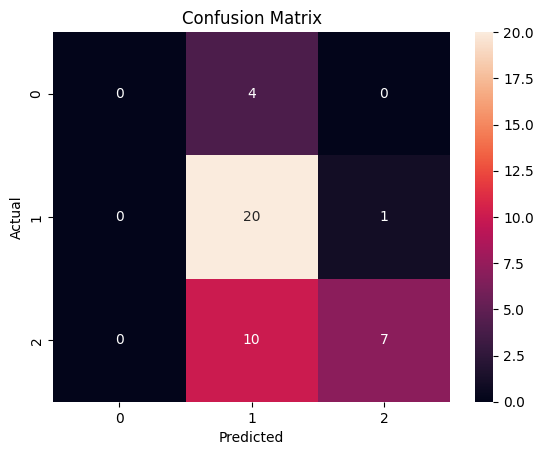

In [539]:
import seaborn as sns
import matplotlib.pyplot as plt

cnfmtx = confusion_matrix(y_test, y_pred)

sns.heatmap(cnfmtx, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Test-Beispiel

In [651]:
# Test Eingaben
test_input = [
    "DAX still on upwards trend besides Euro-Zone being in recession.",
    "Kraken Exchange in fear of its Liquidity due to SEC war.",
    "No significant movement of Ethereum signals upcoming low Volatility-Era in Crypto.",
    "Upwards movement after Bitcoin breaks free from downside trend."
]


# Test Output
for text in test_input:
    processed_input = preprocess_text(text)
    input_vectorized = vectorizer.transform([processed_input])
    prediction = nb_classifier.predict(input_vectorized)
    
    print("Input text:", text)
    print("Predicted class:", prediction)
    print()

Input text: DAX still on upwards trend besides Euro-Zone being in recession.
Predicted class: ['neutral']

Input text: Kraken Exchange in fear of its Liquidity due to SEC war.
Predicted class: ['neutral']

Input text: No significant movement of Ethereum signals upcoming low Volatility-Era in Crypto.
Predicted class: ['positive']

Input text: Upwards movement after Bitcoin breaks free from downside trend.
Predicted class: ['positive']

